In [4]:
import numpy as np 
import matplotlib.pyplot as plt

In [5]:
# --- helpers required by _merge_speed_from_roots ---

import json
from pathlib import Path
import numpy as np

def _fmt_exact(v) -> str:
    """Exact folder token: 10 -> '10', 0.001 -> '0.001' (no sci notation)."""
    v = float(v)
    if v.is_integer():
        return str(int(v))
    s = f"{v:.12f}".rstrip("0").rstrip(".")
    return "0" if s == "-0" else s

def _run_dir_exact(root, lam, alpha, m0):
    """
    Build EXACT path:
      <root>/lambda_<val>/alpha_<val>/m0_<val>
    Returns Path or None if dir doesn't exist.
    """
    d = Path(root) / f"lambda_{_fmt_exact(lam)}" / f"alpha_{_fmt_exact(alpha)}" / f"m0_{_fmt_exact(m0)}"
    return d if d.is_dir() else None

def _slope_vs_time(t, xf, last_frac=0.5):
    t = np.asarray(t, float); xf = np.asarray(xf, float)
    if len(t) < 4 or len(xf) != len(t): return np.nan
    i0 = max(0, int((1.0 - last_frac) * len(t)))
    t_use = t[i0:]; x_use = xf[i0:]
    ok = np.isfinite(t_use) & np.isfinite(x_use)
    if ok.sum() < 3: return np.nan
    A = np.vstack([t_use[ok], np.ones(ok.sum())]).T
    slope, _ = np.linalg.lstsq(A, x_use[ok], rcond=None)[0]
    return float(slope)

def _speed_from_fronts_npz(npz_path):
    """Compute speed from fronts_*.npz via linear fit of x_front(t)."""
    try:
        z = np.load(npz_path, allow_pickle=True)
    except Exception:
        return np.nan
    t = None; xf = None
    for tk in ("t","time","times","T"):
        if tk in z.files: t = z[tk]; break
    for fk in ("x_front","xfront","front","fronts","front_positions","xf"):
        if fk in z.files: xf = z[fk]; break
    if t is None or xf is None: return np.nan
    xf = np.asarray(xf)
    if xf.ndim > 1: xf = xf[..., -1].squeeze()
    return _slope_vs_time(t, xf, last_frac=0.5)

def _speed_from_snapshots_npz(npz_path, threshold=0.5):
    """Fallback: compute speed from snapshots.npz (x, N_arr/u_arr, times)."""
    try:
        z = np.load(npz_path, allow_pickle=True)
    except Exception:
        return np.nan
    x = z.get("x", z.get("X", None))
    u = z.get("N_arr", z.get("u_arr", z.get("N", None)))
    t = z.get("times", z.get("t", z.get("T", None)))
    if x is None or u is None or t is None:
        return np.nan
    x = np.asarray(x); t = np.asarray(t); U = np.asarray(u)
    if U.ndim != 2 or len(t) < 5: return np.nan
    i0 = len(t)//2
    t_use = t[i0:]; x_front = []
    for k in range(i0, len(t)):
        uk = U[k]
        idx = np.where((uk[:-1]-threshold)*(uk[1:]-threshold) <= 0)[0]
        if len(idx)==0: x_front.append(np.nan); continue
        j = idx[0]; xj,xj1 = x[j],x[j+1]; uj,uj1 = uk[j],uk[j+1]
        frac = 0.0 if uj1==uj else (threshold-uj)/(uj1-uj)
        x_front.append(xj + frac*(xj1-xj))
    return _slope_vs_time(t_use, np.asarray(x_front,float), last_frac=1.0)

def _speed_from_summary_json(dirpath, which="N"):
    f = Path(dirpath) / "summary.json"
    if not f.is_file(): return np.nan
    try:
        obj = json.loads(f.read_text())
    except Exception:
        return np.nan
    w = str(which).upper()
    keys = ["speed","c","wave_speed"]
    if w == "N": keys = ["speed_N","c_N"] + keys
    if w == "M": keys = ["speed_M","c_M"] + keys
    for k in keys:
        if k in obj:
            try:
                val = float(obj[k])
                if np.isfinite(val): return val
            except Exception:
                pass
    return np.nan

def _load_speed(dirpath, which="N"):
    """
    Priority inside EXACT dir:
      1) summary.json
      2) fronts_{N|M}.npz (then generic fronts*.npz)
      3) snapshots.npz
    Returns float or np.nan.
    """
    if dirpath is None: return np.nan
    d = Path(dirpath)
    if not d.is_dir(): return np.nan

    # 1) summary.json
    val = _speed_from_summary_json(d, which=which)
    if np.isfinite(val): return val

    # 2) fronts
    prefer = []
    if str(which).upper() == "N":
        prefer += ["fronts_N.npz", "front_N.npz"]
    else:
        prefer += ["fronts_M.npz", "front_M.npz"]
    prefer += ["fronts.npz", "front.npz", "front_positions.npz"]
    for name in prefer:
        f = d / name
        if f.is_file():
            val = _speed_from_fronts_npz(f)
            if np.isfinite(val): return val

    # any other front*.npz
    for f in sorted(d.glob("front*.npz")):
        val = _speed_from_fronts_npz(f)
        if np.isfinite(val): return val

    # 3) snapshots
    snap = d / "snapshots.npz"
    if snap.is_file():
        val = _speed_from_snapshots_npz(snap)
        if np.isfinite(val): return val

    return np.nan

In [3]:
plot_lambda_lines_by_m0_grid(
    base_dirs=("speeds_func_l", "speeds_func_u"),  # 'speeds_func_4' auto-prepended if it exists
    alphas=(1e-3, 1e-1, 1e3, 1e6),
    font_scale=1.15,
    legend_anchor=0.90,
    save=True
)

NameError: name 'plot_lambda_lines_by_m0_grid' is not defined

In [6]:
def plot_wavespeed_alpha_grid(
    base_dirs=("speeds_func_l", "speeds_func_u"),
    alpha_rows=((1e-3, 1e-2, 1e-1), (1e3, 1e4, 1e5)),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e5, 1e6, 1e7, 1e8),
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    which_speed="N",
    cmap="plasma",
    levels=20,
    fig_size=(18, 9),
    # ---- unified font control ----
    font_scale=1.0,
    tick_fs=None,
    label_fs=None,
    title_fs=None,
    cbar_fs=None,
    suptitle=None,
    debug=False
):
    """
    Draw a grid of wavespeed heatmaps vs λ (x) and m0 (y) for multiple α values.
    Colorbar ticks are reduced to [min, min+1/3Δ, min+2/3Δ, max] per panel.
    """
    # auto-join speeds_func_4 (if present) before everything else
    roots = _augment_roots(base_dirs)

    # Resolve fonts
    tick_fs  = int(round((tick_fs  if tick_fs  is not None else 11) * font_scale))
    label_fs = int(round((label_fs if label_fs is not None else 14) * font_scale))
    title_fs = int(round((title_fs if title_fs is not None else 16) * font_scale))
    cbar_fs  = int(round((cbar_fs  if cbar_fs is not None else 12) * font_scale))
    suptitle_text = suptitle if suptitle is not None else r"Wavespeed heatmaps vs $\lambda$ and $m_0$ across $\alpha$"

    alpha_rows  = tuple(tuple(float(a) for a in row) for row in alpha_rows)
    m0_vals     = np.asarray(m0_vals, dtype=float)
    lambda_vals = np.asarray(lambda_vals, dtype=float)

    X, Y = np.meshgrid(np.log10(lambda_vals), m0_vals)

    # Precompute H per panel (EXACT lookups)
    H_mats = []
    for row in alpha_rows:
        row_mats = []
        for alpha in row:
            H = np.full((len(m0_vals), len(lambda_vals)), np.nan, dtype=float)
            for i, m0 in enumerate(m0_vals):
                for j, lam in enumerate(lambda_vals):
                    val = _merge_speed_from_roots(roots, lam, alpha, m0, which=which_speed)
                    H[i, j] = val
                    if debug:
                        print(f"root=* exact, α={alpha:g}, m0={m0:g}, λ={lam:g} -> {val}")
            row_mats.append(H)
        H_mats.append(row_mats)

    nrows, ncols = len(alpha_rows), len(alpha_rows[0])
    fig, axes = plt.subplots(nrows, ncols, figsize=fig_size, constrained_layout=True, squeeze=False)

    fmt = lambda v: f"{float(v):.3g}"  # neat labels

    for r in range(nrows):
        for c in range(ncols):
            ax = axes[r, c]
            H  = H_mats[r][c]
            Hm = np.ma.masked_invalid(H)

            # Per-panel autoscale
            if np.isfinite(Hm).any():
                vmin, vmax = float(np.nanmin(Hm)), float(np.nanmax(Hm))
                if vmin == vmax:
                    vmax = vmin + 1e-9
            else:
                vmin, vmax = 0.0, 1.0

            cf = ax.contourf(X, Y, Hm, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)

            # Per-panel colorbar with only 4 ticks: min, 2 mids, max
            cbar = fig.colorbar(cf, ax=ax, fraction=0.046, pad=0.04)
            ticks = [vmin,
                     vmin + (vmax - vmin) / 3.0,
                     vmin + 2.0 * (vmax - vmin) / 3.0,
                     vmax]
            cbar.set_ticks(ticks)
            ##cbar.set_ticklabels([fmt(t) for t in ticks])
            cbar.set_ticklabels([f"{float(t):.2f}" for t in ticks])
            cbar.ax.tick_params(labelsize=cbar_fs)
            cbar.set_label("Estimated wave speed", fontsize=cbar_fs)

            ax.set_title(_alpha_title(alpha_rows[r][c]), fontsize=title_fs)

            # Axes labeling
            if r == nrows - 1:
                ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=label_fs)
            else:
                ax.set_xticklabels([])

            if c == 0:
                ax.set_ylabel(r"$m_0$", fontsize=label_fs)
            else:
                ax.set_yticklabels([])

            # Decade ticks along x
            decades = np.unique(np.floor(np.log10(lambda_vals)).astype(int))
            ax.set_xticks(decades)
            ax.set_xticklabels([f"{d:d}" for d in decades], fontsize=tick_fs)
            ax.tick_params(axis="y", labelsize=tick_fs)

    fig.suptitle(suptitle_text, fontsize=label_fs + int(round(10 * font_scale)))
    plt.show()
    return fig, axes

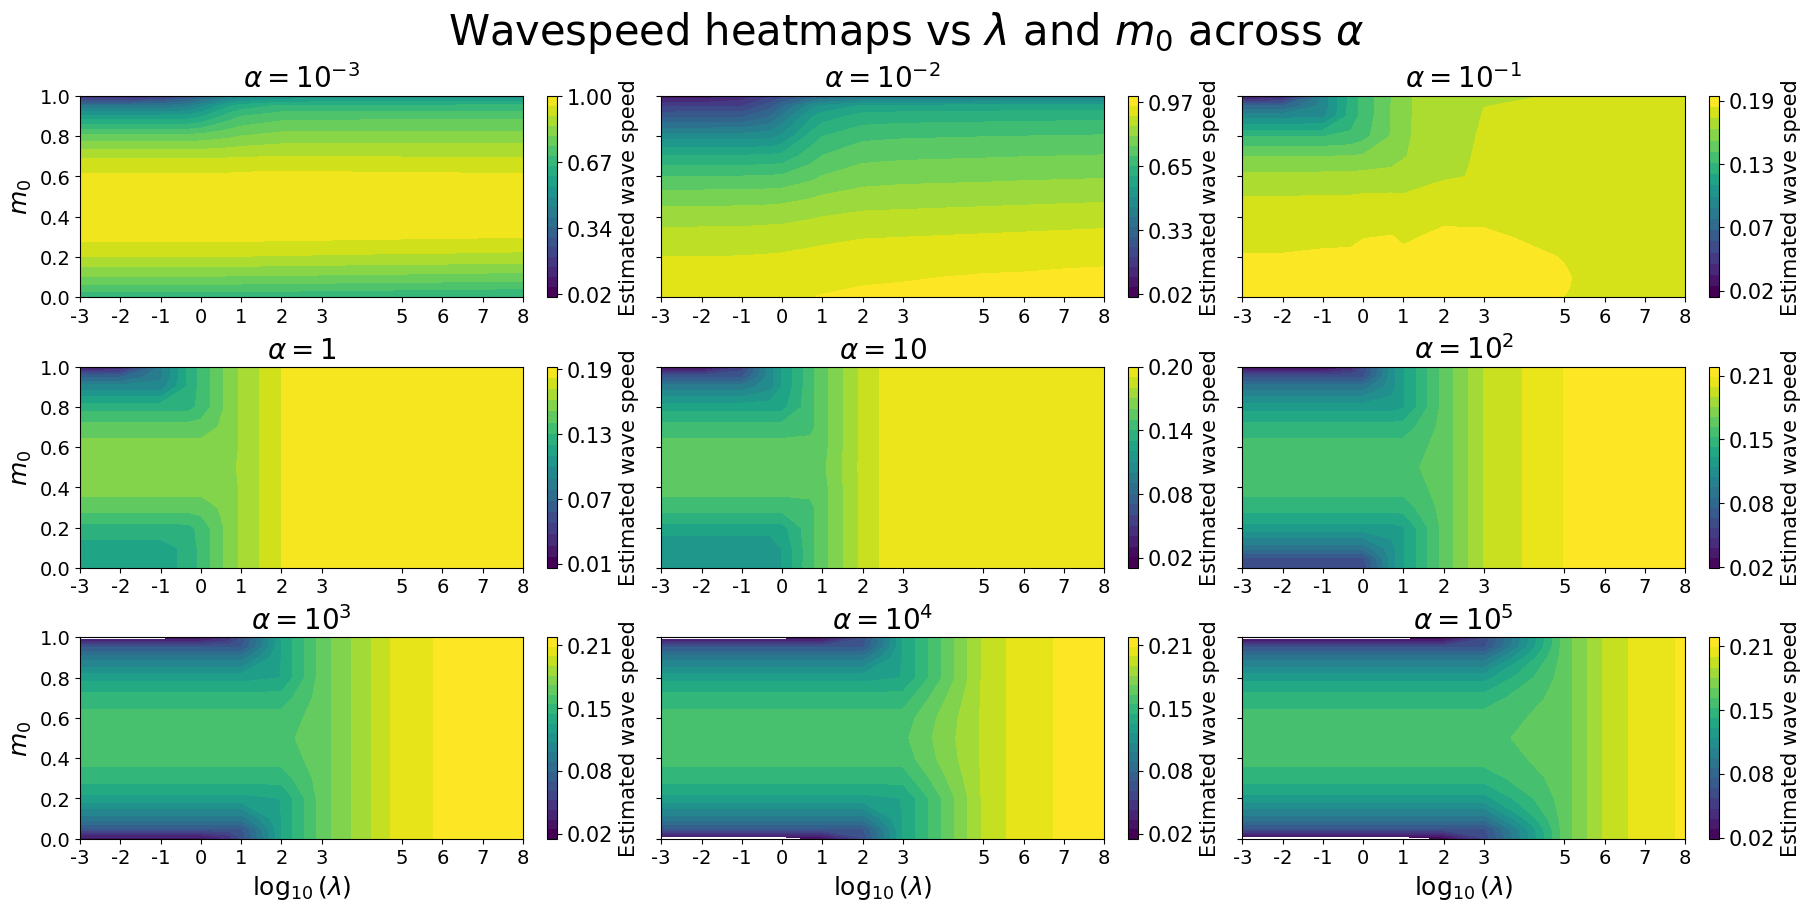

In [14]:
fig, axes = plot_wavespeed_alpha_grid(
    base_dirs=("speeds_func_l", "speeds_func_u"),   # 'speeds_func_4' is auto-prepended if it exists
    alpha_rows=((1e-3, 1e-2, 1e-1), (1, 10, 100), (1e3, 1e4, 1e5)),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e5, 1e6, 1e7, 1e8),
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    cmap="viridis",
    font_scale=1.25,
)

In [7]:
fig, axes = plot_wavespeed_alpha_grid(
    base_dirs=("speeds_func_l", "speeds_func_u"),   # 'speeds_func_4' is auto-prepended if it exists
    alpha_rows=((1e-3, 1e-2, 1e-1), (1, 10, 100), (1e3, 1e4, 1e5), (1e6, 1e7, 1e8)),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e5, 1e6, 1e7, 1e8),
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    cmap="viridis",
    font_scale=1.25,
)

NameError: name '_augment_roots' is not defined

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import os

# --- assumes you have _merge_speed_from_roots(...) in scope ---

def _augment_roots(base_dirs):
    """Prepend 'speeds_func_4' if it exists, then de-dup while keeping order."""
    if isinstance(base_dirs, (str, os.PathLike)):
        base_dirs = (base_dirs,)
    roots = [str(b) for b in base_dirs]
    patch = "speeds_func_4"
    if os.path.isdir(patch):
        roots = [patch] + roots
    seen, out = set(), []
    for r in roots:
        if r not in seen:
            seen.add(r); out.append(r)
    return tuple(out)

def _nanfilter(*arrs):
    mask = np.ones_like(np.asarray(arrs[0]), dtype=bool)
    for a in arrs:
        a = np.asarray(a)
        mask &= np.isfinite(a)
    return [np.asarray(a)[mask] for a in arrs]

def _build_speed_grid_for_m0(*, base_dirs, alphas, lambda_vals, m0, which_speed="N", warn_missing=True):
    # NEW: auto-include speeds_func_4
    base_dirs = _augment_roots(base_dirs)

    if isinstance(base_dirs, (str, Path)):
        base_dirs = (base_dirs,)
    base_dirs = tuple(str(Path(b)) for b in base_dirs)

    A, L = len(alphas), len(lambda_vals)
    C = np.full((A, L), np.nan, float)
    for i, a in enumerate(alphas):
        for j, lam in enumerate(lambda_vals):
            cval = _merge_speed_from_roots(base_dirs, float(lam), float(a), float(m0), which=which_speed)
            C[i, j] = cval
    return C

def _flatten_samples(lambdas, alphas, C):
    """Return flat arrays lam_s, alp_s, c_s from grids."""
    L = len(lambdas); A = len(alphas)
    lam_grid = np.broadcast_to(np.asarray(lambdas)[None, :], (A, L))
    alp_grid = np.broadcast_to(np.asarray(alphas)[:, None], (A, L))
    return lam_grid.ravel(), alp_grid.ravel(), np.asarray(C).ravel()

def plot_speed_scatter_compare_by_m0(
    *,
    base_dirs=("speeds_func_l", "speeds_func_u"),
    alphas=(1e-3, 1e-2, 1e-1, 1, 10, 1e3, 1e5, 1e8),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e6, 1e8),
    m0_vals=(0.0, 0.5, 1.0),
    which_speed="N",
    point_size=22,
    save=False,
    out_prefix="scatter_compare"
):
    """
    For each m0 in m0_vals, make a figure with two subplots:
      (left)  c vs lambda  (colour = alpha, log colour scale)
      (right) c vs alpha   (colour = lambda, log colour scale)
    """
    alphas = np.asarray(alphas, float)
    lambdas = np.asarray(lambda_vals, float)

    for m0 in m0_vals:
        # build grid and flatten
        C = _build_speed_grid_for_m0(
            base_dirs=base_dirs, alphas=alphas, lambda_vals=lambdas, m0=m0, which_speed=which_speed
        )
        lam_s, alp_s, c_s = _flatten_samples(lambdas, alphas, C)
        lam_s, alp_s, c_s = _nanfilter(lam_s, alp_s, c_s)

        # figure with two panels
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.6))

        # (1) c vs lambda, colour by alpha
        sc1 = ax1.scatter(lam_s, c_s, c=alp_s,
                          norm=LogNorm(vmin=alp_s.min(), vmax=alp_s.max()),
                          s=point_size)
        ax1.set_xscale('log')
        ax1.set_xlabel(r"$\lambda$")
        ax1.set_ylabel("Wave speed")
        ax1.set_title(rf"$c$ vs $\lambda$ (colour = $\alpha$)   $m_0={m0:g}$")
        cbar1 = plt.colorbar(sc1, ax=ax1, pad=0.01)
        cbar1.set_label(r"$\alpha$ (log colour scale)")
        ax1.grid(True, which='both', alpha=0.3)

        # (2) c vs alpha, colour by lambda
        sc2 = ax2.scatter(alp_s, c_s, c=lam_s,
                          norm=LogNorm(vmin=lam_s.min(), vmax=lam_s.max()),
                          s=point_size)
        ax2.set_xscale('log')
        ax2.set_xlabel(r"$\alpha$")
        ax2.set_ylabel("Wave speed")
        ax2.set_title(rf"$c$ vs $\alpha$ (colour = $\lambda$)   $m_0={m0:g}$")
        cbar2 = plt.colorbar(sc2, ax=ax2, pad=0.01)
        cbar2.set_label(r"$\lambda$ (log colour scale)")
        ax2.grid(True, which='both', alpha=0.3)

        fig.suptitle("Speed comparison: degradation vs regeneration", y=1.02, fontsize=14)
        fig.tight_layout()

        if save:
            os.makedirs(os.path.dirname(out_prefix) or ".", exist_ok=True)
            fn = f"{out_prefix}_m0_{m0:g}.png"
            fig.savefig(fn, dpi=300, bbox_inches="tight")
        plt.show()

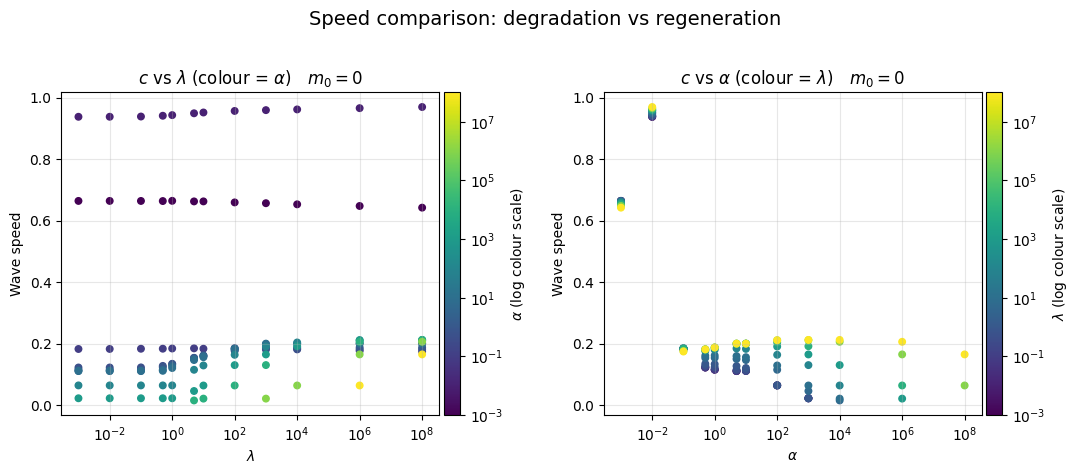

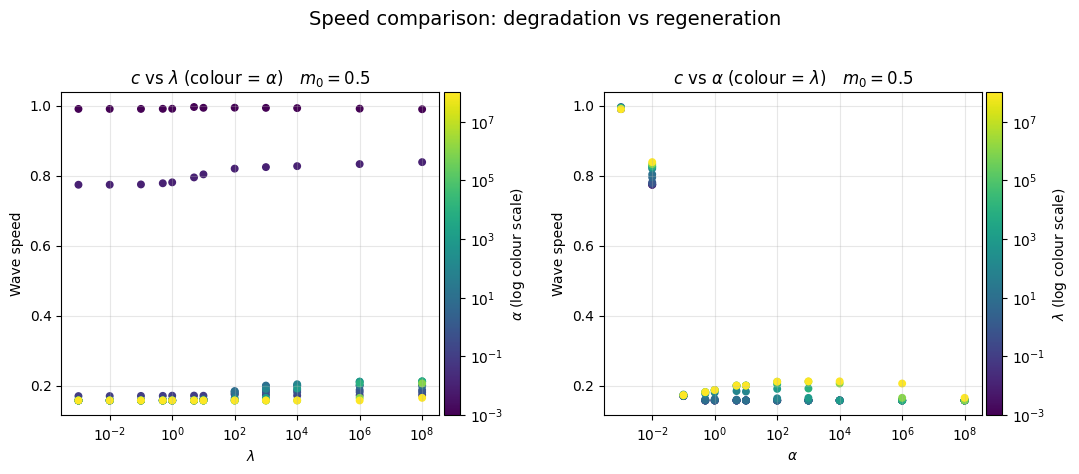

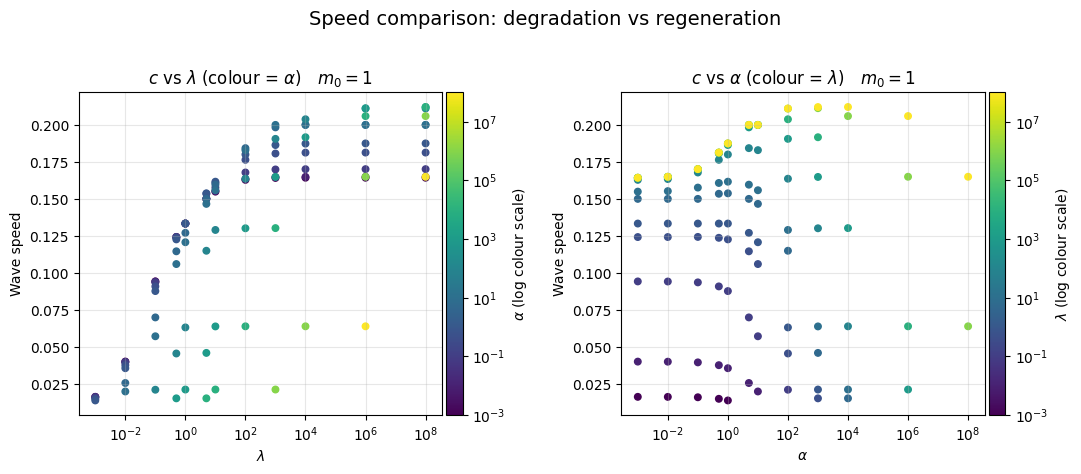

In [16]:
plot_speed_scatter_compare_by_m0(
    base_dirs=("speeds_func_l", "speeds_func_u"),  # 'speeds_func_4' is auto-prepended if present
    alphas=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e6, 1e8),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e6, 1e8),
    m0_vals=(0.0, 0.5, 1.0),
    which_speed="N",
    save=False
)

In [25]:
import os, re, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ---------- defaults ----------
DEFAULT_LAMBDAS = (1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e5, 1e6, 1e7, 1e8)
DEFAULT_ALPHAS  = (0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1e3, 1e5, 1e6, 1e7, 1e8)
##DEFAULT_M0S     = ( 0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5,)
DEFAULT_M0S     = (0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1)

# ---------- token helpers ----------
_num_pat = re.compile(r"([0-9eE\.\-]+)$")

def _token_variants(v: float):
    v = float(v)
    dec = f"{v:.12f}".rstrip("0").rstrip(".")
    plain = f"{v:g}"
    sci = f"{v:.0e}"
    s, e = sci.split("e")
    sci_neat = f"{s}e{int(e)}"
    toks = {dec, plain, sci, sci_neat}
    toks |= {t.replace(".", "p") for t in list(toks)}  # allow 0p5-style
    return toks

def _exactish_dir(parent: Path, prefix: str, value: float):
    """Return parent/prefix_<token> if any token matches exactly (string)."""
    if not parent.exists():
        return None
    for tok in _token_variants(value):
        p = parent / f"{prefix}_{tok}"
        if p.is_dir():
            return p
    return None

def _closest_dir_by_number(parent: Path, prefix: str, target: float):
    """Numeric fallback (only used if exactish failed)."""
    if not parent.exists():
        return None
    cands = [d for d in parent.iterdir() if d.is_dir() and d.name.startswith(prefix + "_")]
    if not cands:
        return None
    def take_num(p: Path):
        m = _num_pat.search(p.name)
        try:
            return float(m.group(1)) if m else None
        except Exception:
            return None
    pairs = [(p, take_num(p)) for p in cands]
    pairs = [(p, v) for p, v in pairs if v is not None]
    if not pairs:
        return None
    return min(pairs, key=lambda pv: abs(pv[1] - float(target)))[0]

def _augment_roots_by_m0(base_dirs, m0: float):
    """Prefer patch folder then correct family (u if m0≥0.5 else l)."""
    if isinstance(base_dirs, (str, os.PathLike)):
        base_dirs = (base_dirs,)
    roots = [str(b) for b in base_dirs]
    patch = "speeds_func_4"
    if os.path.isdir(patch):
        roots = [patch] + roots
    # ensure correct family comes before the other
    want = "speeds_func_u" if float(m0) >= 0.5 else "speeds_func_l"
    other = "speeds_func_l" if want == "speeds_func_u" else "speeds_func_u"
    ordered = []
    for r in (want, other):
        if r in roots:
            ordered.append(r)
    # keep any other custom roots in their relative order after the two families
    for r in roots:
        if r not in ordered:
            ordered.append(r)
    # de-dup
    seen, out = set(), []
    for r in ordered:
        if r not in seen:
            seen.add(r); out.append(r)
    return tuple(out)

def _summary_speed(p: Path, which="N"):
    if p is None:
        return np.nan
    s = p / "summary.json"
    if not s.exists():
        return np.nan
    try:
        meta = json.loads(s.read_text())
        if str(which).upper() == "N":
            keys = ("speed_N", "c_N", "wave_speed", "speed", "c")
        else:
            keys = ("speed_M", "c_M", "m_wave_speed", "wave_speed", "speed", "c")
        for k in keys:
            if k in meta:
                try:
                    val = float(meta[k])
                    if np.isfinite(val):
                        return val
                except Exception:
                    pass
    except Exception:
        pass
    return np.nan

# ----- finders that respect family + exactish matching -----
def _find_plain_dir_multi(roots, lam, m0):
    roots = _augment_roots_by_m0(roots, m0)
    for root in roots:
        base = Path(root)
        lam_dir = _exactish_dir(base, "lambda", lam) or _closest_dir_by_number(base, "lambda", lam)
        if lam_dir is None:
            continue
        # m0 MUST match exactish; do NOT silently take nearest
        m_dir = _exactish_dir(lam_dir, "m0", m0)
        if m_dir is not None:
            return m_dir
    return None

def _find_source_dir_multi(roots, fixed_lambda, alpha, m0):
    roots = _augment_roots_by_m0(roots, m0)
    for root in roots:
        base = Path(root)
        lam_dir = _exactish_dir(base, "lambda", fixed_lambda) or _closest_dir_by_number(base, "lambda", fixed_lambda)
        if lam_dir is None:
            continue
        a_dir = _exactish_dir(lam_dir, "alpha", alpha) or _closest_dir_by_number(lam_dir, "alpha", alpha)
        if a_dir is None:
            continue
        # m0 MUST match exactish
        m_dir = _exactish_dir(a_dir, "m0", m0)
        if m_dir is not None:
            return m_dir
    return None

# ---------- main line-plotter ----------
def plot_speed_vs_log_param_lines(
    *,
    # WHAT to sweep
    param="alpha",                                  # "alpha" or "lambda"
    base_dirs=("speeds_func_l", "speeds_func_u"),   # can be one or many roots
    param_values=None,                              # defaults set below
    m0_vals=DEFAULT_M0S,
    fixed_lambda=0.1,                               # used when param="alpha"

    # styling
    title=None,
    xlabel=None,
    ylabel="Numerically estimated wave speed",
    cmap_name="plasma",
    ms=6, lw=2.5,
    tick_fs=13, label_fs=16, title_fs=20, legend_fs=12,

    # behavior
    warn_missing=True,
    save=False, outpath=None
):
    """
    Draw line plot: speed vs log10(param), one curve per m0.
    Uses exactish folder matches (tokens like 0.5/0p5/5e-1);
    prefers speeds_func_4 and the correct family (u/l) for the given m0.
    """

    if param_values is None:
        param_values = DEFAULT_ALPHAS if param == "alpha" else DEFAULT_LAMBDAS

    pvals = np.asarray(param_values, float)
    logx  = np.log10(pvals)

    fig, ax = plt.subplots(figsize=(10, 6))
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / max(1, len(m0_vals)-1)) for i in range(len(m0_vals))]

    missing = 0
    for k, m0 in enumerate(m0_vals):
        ys = []
        # choose roots per m0
        roots_m0 = _augment_roots_by_m0(base_dirs, m0)
        for v in pvals:
            if param == "alpha":
                m_dir = _find_source_dir_multi(roots_m0, fixed_lambda, v, m0)
                label_root = f"lambda_{fixed_lambda}"
                label_param = f"alpha_{v}"
            else:
                m_dir = _find_plain_dir_multi(roots_m0, v, m0)
                label_root = None
                label_param = f"lambda_{v}"

            c = _summary_speed(m_dir, which="N")
            if not np.isfinite(c):
                ys.append(np.nan)
                if warn_missing:
                    where = (label_root + "/") if label_root else ""
                    print(f"[warn] missing speed for m0_{m0} under {where}{label_param} (searched {len(roots_m0)} roots)")
                missing += 1
            else:
                ys.append(c)

        ys = np.asarray(ys, float)
        ax.plot(logx, ys, "-o", color=colors[k], lw=lw, ms=ms, label=rf"{m0:g}")

    # labels/titles
    if xlabel is None:
        xlabel = r"$\log_{10}(\alpha)$" if param=="alpha" else r"$\log_{10}(\lambda)$"
    ax.set_xlabel(xlabel, fontsize=label_fs)
    ax.set_ylabel(ylabel, fontsize=label_fs)

    if title is None:
        title = r"Initial value of ECM $(m_0)$ vs $\alpha$" if param=="alpha" \
                else r"Initial value of ECM $(m_0)$ vs $\lambda$"
    ax.set_title(title, fontsize=title_fs)

    ax.tick_params(axis="both", labelsize=tick_fs)
    ax.grid(True, linestyle="--", alpha=0.25)

    ax.legend(
        title=r"$m_0$", fontsize=legend_fs, title_fontsize=legend_fs,
        loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=True
    )
    fig.tight_layout(rect=[0, 0, 0.85, 1])

    if save:
        if outpath is None:
            outpath = Path("plots") / f"speed_vs_log_{param}.png"
        Path(outpath).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved to {outpath}")
    else:
        plt.show()

    if missing and warn_missing:
        print(f"[info] missing/NaN points: {missing}")
    return fig, ax

[warn] missing speed for m0_0 under lambda_100/alpha_1000000.0 (searched 3 roots)
[warn] missing speed for m0_0 under lambda_100/alpha_10000000.0 (searched 3 roots)
[warn] missing speed for m0_0 under lambda_100/alpha_100000000.0 (searched 3 roots)
[warn] missing speed for m0_1 under lambda_100/alpha_1000000.0 (searched 3 roots)
[warn] missing speed for m0_1 under lambda_100/alpha_10000000.0 (searched 3 roots)
[warn] missing speed for m0_1 under lambda_100/alpha_100000000.0 (searched 3 roots)


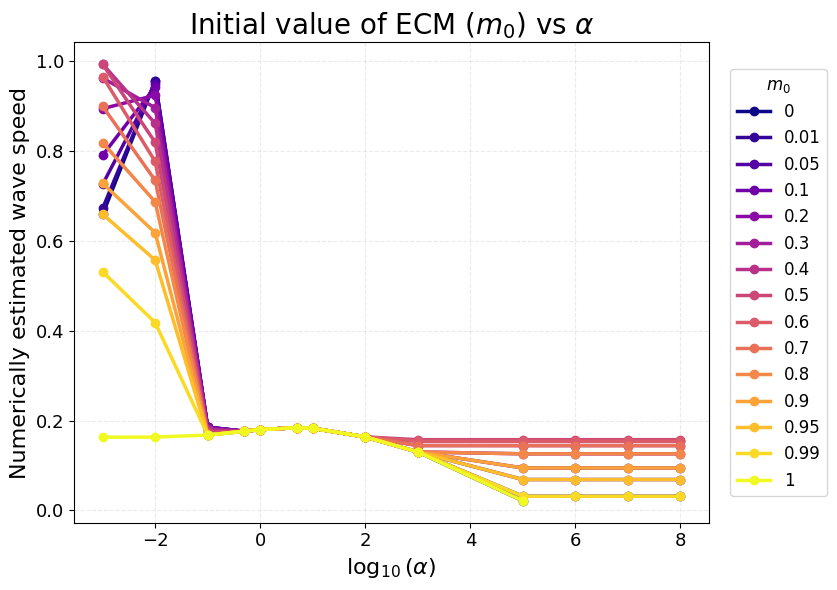

[info] missing/NaN points: 6


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Initial value of ECM $(m_0)$ vs $\\alpha$'}, xlabel='$\\log_{10}(\\alpha)$', ylabel='Numerically estimated wave speed'>)

In [28]:
plot_speed_vs_log_param_lines(
    param="alpha",
    base_dirs=("speeds_func_l", "speeds_func_u"),  # speeds_func_4 auto-prepended if present
    fixed_lambda=100
)